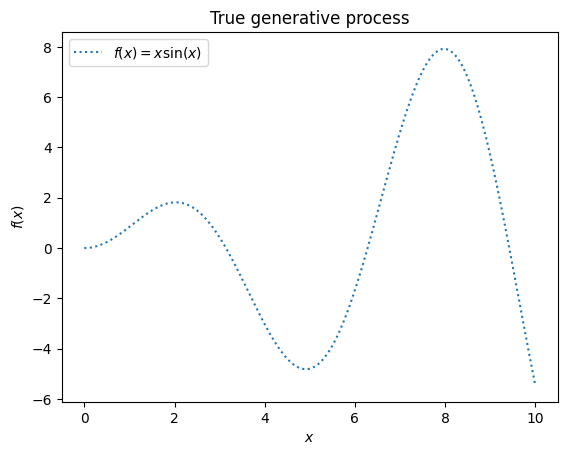

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

x = np.linspace(start = 0,stop = 10,num=1000).reshape(-1,1)
y = np.squeeze(x*np.sin(x))

plt.plot(x, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [8]:
rng = np.random.RandomState()
training_indices = rng.choice(np.arange(y.size), size = 6, replace = False)
x_train, y_train = x[training_indices], y[training_indices]


kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(x_train, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=9)

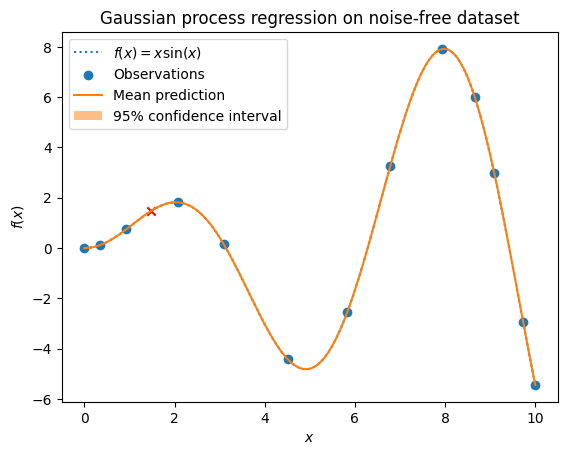

In [20]:
mean_prediction, std_prediction = gaussian_process.predict(x, return_std=True)
max_std_ind = np.argmax(std_prediction)
plt.plot(x, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(x_train, y_train, label="Observations")
plt.plot(x, mean_prediction, label="Mean prediction")
plt.fill_between(
    x.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")
plt.scatter(x[max_std_ind],mean_prediction[max_std_ind],c='red',marker='x')

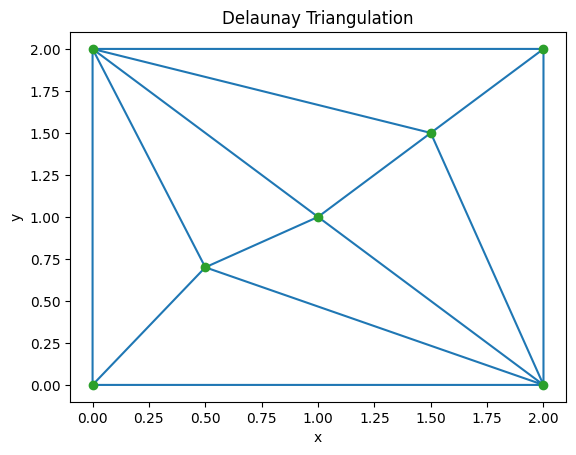

Indices of triangles' vertices:
[[2 6 1]
 [6 3 1]
 [4 6 2]
 [3 6 4]
 [5 4 0]
 [5 3 4]
 [5 0 1]
 [3 5 1]]


In [6]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# Sample scatter points
points = np.array([
    [2,2], [0,2], [0, 0], [1, 1], [2, 0], [1.5, 1.5], [0.5, 0.7]
])

# Perform Delaunay triangulation
tri = Delaunay(points)

# Plot the triangulation
plt.triplot(points[:, 0], points[:, 1], tri.simplices)
plt.plot(points[:, 0], points[:, 1], 'o')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Delaunay Triangulation")
plt.show()

# Access triangulation information
print("Indices of triangles' vertices:")
print(tri.simplices)

In [19]:
iter = 1
for i in range(iter):
    new_x = x[max_std_ind]
    new_y = y[max_std_ind]
    x_train_new = np.append(x_train, new_x).reshape(-1,1)
    y_train_new = np.append(y_train, new_y)
    gaussian_process.fit(x_train_new,y_train_new)
    mean_prediction, std_prediction = gaussian_process.predict(x, return_std=True)
    max_std_ind = np.argmax(std_prediction)
    x_train, y_train = x_train_new, y_train_new

C:\Users\broke\AppData\Roaming\Python\Python311\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
import sklearn.gaussian_process.kernels as k
import matplotlib.pyplot as plt
from scipy.stats import qmc

def time_dependent_function(time, laser, ratios):
    laser_time = laser*np.ones(len(time)).reshape(-1,1)
    mat_time = (ratios[0] + ((ratios[1]-ratios[0])/time.max())*time).reshape(-1,1)
    T = (0.3*np.cos(20*np.pi*time/time.max()) + 150*np.log(laser_time[:,0]**2) - 30*(mat_time[:,0]**2)
         + 10*np.random.rand(len(time))).reshape(-1,1)
    A = (2*mat_time[:,0]*np.sin(np.pi*(time+mat_time[:,0])/(2*time.max())) - (T[:,0]/1000)**2 + 5).reshape(-1,1)
    h = (5 / (A**2)).reshape(-1,1)
    w = (1/2 * A).reshape(-1,1)
    x_sample = np.concatenate((time.reshape(-1,1), laser_time, mat_time, T, A),axis=1)
    y_sample = np.concatenate((h,w),axis=1)
    return x_sample, y_sample


scaler = StandardScaler()
samples = 20
sampler = qmc.LatinHypercube(d=3)
L_R_samples = sampler.random(n=samples)
L_R_samples = qmc.scale(L_R_samples,[400, 0, 0],[700, 1, 1])
time = np.arange(0,20)
x_train = np.zeros((len(time)*samples, 5))
y_train = np.zeros((len(time)*samples,2))
for i in range(samples):
    x_curr, y_curr = time_dependent_function(time,L_R_samples[i,0],L_R_samples[i,1:])
    x_train[(i*len(time)):(len(time)*(i+1)),:] = x_curr
    y_train[(i*len(time)):(len(time)*(i+1)),:] = y_curr
scaled_X_train = scaler.fit_transform(x_train)
kernel = 5*k.Matern()+k.RBF()
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25)
gaussian_process.fit(scaled_X_train, y_train)

C:\Users\broke\AppData\Roaming\Python\Python311\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\broke\AppData\Roaming\Python\Python311\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\broke\AppData\Roaming\Python\Python311\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a b

GaussianProcessRegressor(kernel=2.24**2 * Matern(length_scale=1, nu=1.5) + RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=25)

In [40]:

def closest_data(time, x_samples, new_sample, x_train):
    distances = np.linalg.norm(x_samples-new_sample, axis=1)
    closest_index = np.argmin(distances)
    laser_time = new_sample[0]*np.ones(len(time)).reshape(-1,1)
    mat_time = (new_sample[1] + ((new_sample[2]-new_sample[1])/time.max())*time).reshape(-1,1)
    signal_train = np.zeros([len(time),2])
    signal_train[:,0] = np.random.normal(np.mean(x_train[(len(time)*closest_index):(len(time)*(closest_index+1)),3]),
                                          np.std(x_train[(len(time)*closest_index):(len(time)*(closest_index+1)),3]),
                                          len(time))
    signal_train[:,1] = np.random.normal(np.mean(x_train[(len(time)*closest_index):(len(time)*(closest_index+1)),4]),
                                         np.std(x_train[(len(time)*closest_index):(len(time)*(closest_index+1)),4]),
                                         len(time))
    x_predict_new = np.concatenate((time.reshape(-1,1),laser_time,mat_time,signal_train),axis=1)
    return x_predict_new

def random_sampler_std(time, samples, bounds, x_old_samples, x_train, gp):
    l_bound = bounds[0]
    u_bound = bounds[1]
    sampler = qmc.LatinHypercube(d=len(l_bound))
    sample = sampler.random(n=samples)
    sample = qmc.scale(sample,l_bound,u_bound)
    total_predict = np.zeros((len(time)*samples, 5))
    for i in range(samples):
        x_train_i = closest_data(time, x_old_samples, sample[i,:], x_train)
        total_predict[(i*len(time)):((i+1)*len(time))] = x_train_i
    scaler = StandardScaler()
    scaler.fit_transform(x_train)
    total_predict = scaler.transform(total_predict)
    _, std_prediction = gp.predict(total_predict,return_std=True)
    std_samples = std_prediction[:,0].reshape(samples,len(time))
    std_max, std_mean = np.max(std_samples, axis = 1), np.mean(std_samples, axis = 1)
    return std_max, std_mean, sample

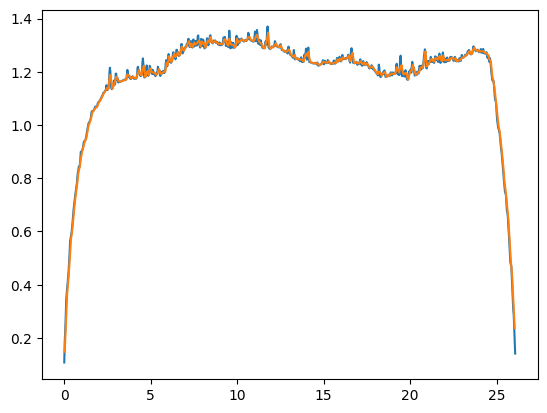

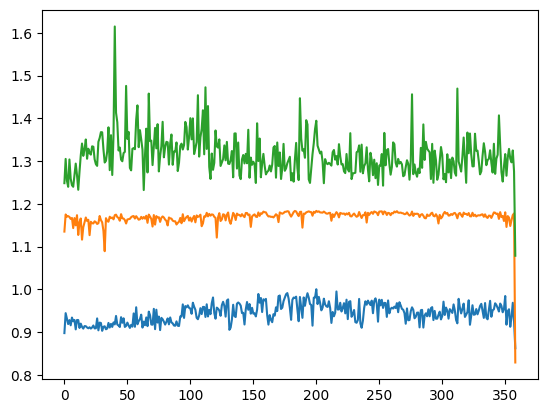

In [56]:
import numpy as np
import matplotlib.pyplot as plt
scanned_data = np.genfromtxt(r"Left Half curve.txt",skip_header=3) * 10**3
temperature_file = np.loadtxt(r"C:\Users\broke\Documents\Northwestern Files\PSED_2025\(250124)-calibration\experiment1-4\exp1_avg_temp.csv",
                              delimiter=',')
props_file = np.loadtxt(r"C:\Users\broke\Documents\Northwestern Files\PSED_2025\(250124)-calibration\experiment1-4\exp1_melt_props.csv",
                        delimiter=',')
mask = np.logical_and(np.logical_not(np.isnan(scanned_data[:,1])), scanned_data[:,1] > 0.1)

tot_x_vals = scanned_data[mask,0] - scanned_data[mask,0][0]
heights = scanned_data[mask,1]
num_points = len(temperature_file)
ind = np.linspace((len(heights)/num_points)*0.5, len(heights) - (len(heights)/num_points)*0.5, num_points, dtype=int)
heights_avg = np.zeros(num_points)
for i in range(num_points):
    ind_i = [np.max([int(ind[i]-(len(heights)/(2*num_points))),0]), np.min([int(ind[i] + (len(heights)/(2*num_points))), len(heights)])]
    heights_avg[i] = np.mean(heights[ind_i[0]:ind_i[1]])
plt.plot(tot_x_vals, heights)
plt.plot(tot_x_vals[ind], heights_avg)
samples_per_length = len(temperature_file)/num_points
print(samples_per_length)
plt.figure()
plt.plot(temperature_file/temperature_file.max())
plt.plot(props_file[:,0]*10**-6)
plt.plot(props_file[:,1]*10**-3)

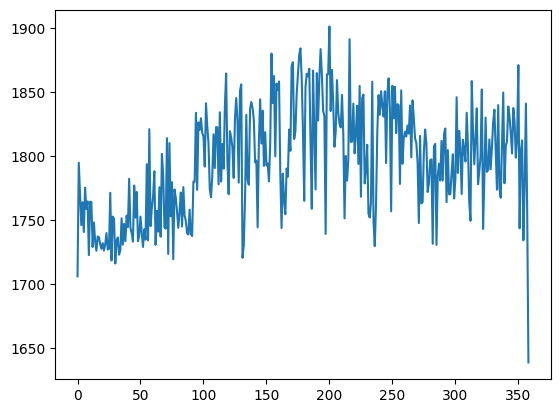

In [155]:
plt.plot(temperature_file)

In [57]:
x_train = np.concatenate((temperature_file.reshape(-1,1), (props_file[:,0]*10**-6).reshape(-1,1), (props_file[:,1]*10**-3).reshape(-1,1)), axis = 1)
y_train = heights_avg

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
import sklearn.gaussian_process.kernels as k

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(x_train)
kernel = k.RBF()+10*k.Matern()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25)
gp.fit(scaled_X_train, y_train)

(359, 3) (359,)


GaussianProcessRegressor(kernel=RBF(length_scale=1) + 3.16**2 * Matern(length_scale=1, nu=1.5),
                         n_restarts_optimizer=25)

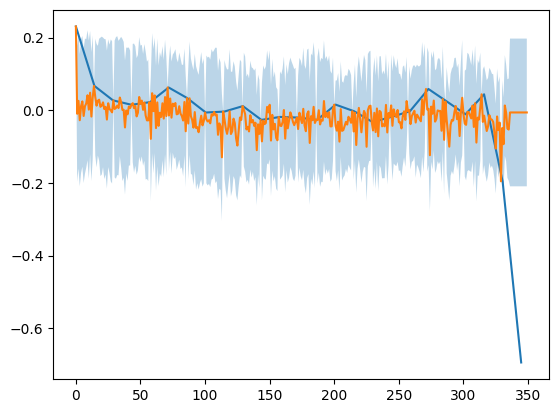

In [95]:
predict_x = np.zeros((14*25, 14*3))
for i in range(14*24):
    predict_x_i = np.concatenate((temperature_file[i:(i+14)], props_file[i:(i+14),0]*10**-6,props_file[i:(i+14),1]*10**-3))
    predict_x[i,:] = predict_x_i

predict_x = scaler.transform(predict_x)
mean_prediction, std_prediction = gp.predict(predict_x, return_std=True)
plt.plot(samples_per_length*np.arange(len(height_slices[1:-1])),np.diff(height_slices[1:]))
plt.plot(mean_prediction)
plt.fill_between(np.arange(14*25), y1 = mean_prediction + std_prediction, y2 = mean_prediction - std_prediction, alpha = 0.3)

In [ ]:
#Include experiment 5
temp_file_2 = np.loadtxt(r"C:\Users\broke\Documents\Northwestern Files\PSED_2025\(250124)-calibration\experiment5-8\exp5_avg_temp.csv", delimiter=',')
props_file_2 = np.loadtxt(r"C:\Users\broke\Documents\Northwestern Files\PSED_2025\(250124)-calibration\experiment5-8\exp5_melt_props.csv", delimiter=',')

mask = np.logical_and(np.logical_not(np.isnan(scanned_data[:,5])), scanned_data[:,5] > 0.1)

tot_x_vals = scanned_data[mask,4] - scanned_data[mask,4][0]
heights = scanned_data[mask,5]
num_points = len(temp_file_2)
ind = np.linspace((len(heights)/num_points)*0.5, len(heights) - (len(heights)/num_points)*0.5, num_points, dtype=int)
heights_avg2 = np.zeros(num_points)
for i in range(num_points):
    ind_i = [np.max([int(ind[i]-(len(heights)/(2*num_points))),0]), np.min([int(ind[i] + (len(heights)/(2*num_points))), len(heights)])]
    heights_avg2[i] = np.mean(heights[ind_i[0]:ind_i[1]])

x_test2 = np.concatenate((temp_file_2.reshape(-1,1), (props_file_2[:,0]*10**-6).reshape(-1,1), (props_file_2[:,1]*10**-3).reshape(-1,1)), axis = 1)

Training conditionals (total: 1): 1
Sampling (total: 600): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 2

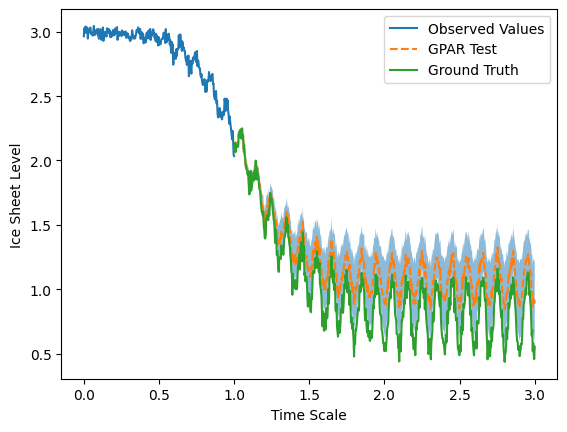

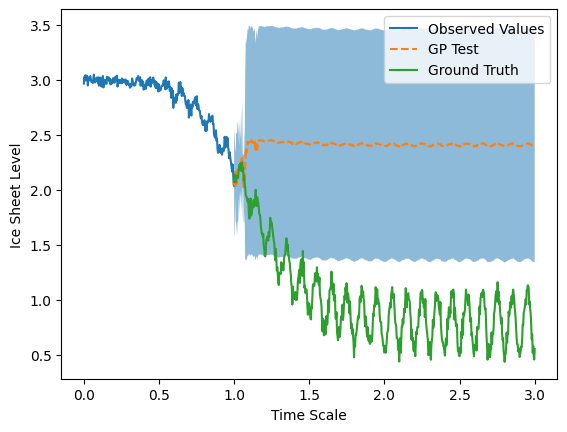

In [ ]:
#Guangzhong start here :)

from gpar import GPARRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
import sklearn.gaussian_process.kernels as k

# Create toy data set.
n_obs = 300
n_test = 600
x_obs = np.linspace(0, 1, n_obs,endpoint=True)
x_test = np.linspace(1,3,n_test, endpoint=True)
noise = 0.025

# Draw functions depending on each other in complicated ways.
C_t_obs = 0.1*np.sqrt(x_obs)*np.cos(20*np.pi*x_obs) + 2 / (1 + np.exp(-5*(x_obs-1.01))) + 1 + noise * np.random.randn(n_obs)
C_t_test  = 0.1*np.sqrt(x_test)*np.cos(20*np.pi*x_test) + 2 / (1 + np.exp(-5*(x_test-1.01))) + 1 + noise * np.random.randn(n_test)
T_t_obs = 1 / (np.sin((C_t_obs**0.2) * np.pi) - 0.5) + 2 + noise * np.random.randn(n_obs)
T_t_test = 1 / (np.sin((C_t_test**0.2) * np.pi) - 0.5) + 2 + noise * np.random.randn(n_test)
I_t_obs = np.cos(T_t_obs) - 0.4*(C_t_obs - 1)**2 + 2 + noise * np.random.randn(n_obs)
I_t_test = np.cos(T_t_test) - 0.4*(C_t_test - 1)**2 + 2 + noise * np.random.randn(n_test)

x_obs_tot = np.stack((C_t_obs, T_t_obs), axis = 1)
x_test_tot = np.stack((C_t_test, T_t_test), axis = 1)
y_obs = I_t_obs.T
y_test = I_t_test.T

model = GPARRegressor(
        scale=0.1,
        linear=True,
        linear_scale=10.0,
        nonlinear=True,
        nonlinear_scale=0.1,
        noise=0.05,
        impute=True,
        replace=False,
        normalise_y=False,
    )
model.fit(x_obs_tot, y_obs)
means, lowers, uppers = model.predict(
        x_test_tot, num_samples=n_test, credible_bounds=True, latent=True
    )

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(x_obs_tot)
kernel = k.RBF() + k.Matern()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25)
gp.fit(scaled_X_train, y_obs)
predict_x = scaler.transform(x_test_tot)
mean_prediction, std_prediction = gp.predict(predict_x, return_std=True)

plt.figure()
plt.plot(x_obs,I_t_obs, label = 'Observed Values')
plt.plot(x_test, means, label='GPAR Test',linestyle='--')
plt.plot(x_test, y_test, label='Ground Truth')
plt.fill_between(x_test, lowers[:,0], uppers[:,0], alpha = 0.5)
plt.xlabel('Time Scale')
plt.ylabel('Ice Sheet Level')
plt.legend()

plt.figure()
plt.plot(x_obs,I_t_obs, label = 'Observed Values')
plt.plot(x_test, mean_prediction, label='GP Test',linestyle='--')
plt.plot(x_test, y_test, label='Ground Truth')
plt.fill_between(x_test, mean_prediction - std_prediction, mean_prediction + std_prediction, alpha = 0.5)
plt.xlabel('Time Scale')
plt.ylabel('Ice Sheet Level')
plt.legend()

y_var = np.var(y_test)
mse_gpar = np.sum((y_test - means[:,0])**2)/n_test
smse_gpar = mse_gpar/y_var
mse_gp = np.sum((y_test - mean_prediction)**2)/n_test
smse_gp = mse_gp/y_var
print(smse_gpar)
print(smse_gp)

In [91]:
sme_gpar = np.sum((y_test - means)**2)/n_test
sme_gp = np.sum((y_test - mean_prediction)**2)/n_test

In [51]:
import sys

import numpy as np
import wbml.out
from lab import B
from wbml.data.air_temp import load as load_temp
from wbml.experiment import WorkingDirectory

from gpar import GPARRegressor


def convert_index(df):
    index = df.index - d_all.index[0]
    return np.array([td.total_seconds() / 3600 / 24 for td in index])

B.epsilon = 1e-6
wbml.out.report_time = True
wd = WorkingDirectory("_experiments", "air_temp")

# Load data.
d_all, d_train, d_tests = load_temp()
print(d_all.shape)

# Determine the number of inducing points.
n_ind = [10 * 10 + 1, 10 * 15 + 1, 10 * 31 + 1]

# Place inducing points evenly spaced.
x = convert_index(d_all)
x_ind = np.linspace(x.min(), x.max(), n_ind)

# Fit and predict GPAR. NOTE: we use D-GPAR-L-NL here, as opposed to D-GPAR-L,
# to make the results a little more drastic.
model = GPARRegressor(
        scale=0.2,
        linear=True,
        linear_scale=10.0,
        nonlinear=True,
        nonlinear_scale=1.0,
        noise=0.1,
        impute=True,
        replace=True,
        normalise_y=True,
        x_ind=x_ind,
    )
model.fit(convert_index(d_train), d_train.to_numpy())


KeyboardInterrupt: 